In [22]:
## what do i need? i need the temp, the radius (from the model) and i need the distance.
## the temp i can get from the luminosity and the radius and the velocity
## i am left with the distance ok got the distance good
from astropy import units as u
import astropy

distance = 26.4 * 10**6 * u.pc

R_e = {3/2: 3.07 * 10**12 * u.cm, 3: 4.57 * 10**12 * u.cm}

v_e = {3/2: 2.47 * 10**9 * u.cm / u.s, 3: 2.69 * 10**9 * u.cm / u.s}

M_e = {3/2: 3.99 * 10**-2 * u.solMass, 3: 38.34 * 10**-2 * u.solMass}




In [33]:

## we set M_c = M_sun becuase the dependence is very week
M_c = 1 * u.solMass

## M = Me + Mc
M = lambda n: M_e[n] + M_c

## vs,8.5 is the velocity of the shock vs in units of 10^8.5 cm s−1
v = lambda n: v_e[n] / (10**8.5)

## where R13 = Re/10^13 cm
R_13 = lambda n: R_e[n] / (10**13)

## where k0.34 is the opacity in units of 0.34 cm2 g−1
## where k0.34 is the opacity in units of 0.34 cm2 g−1
k = 1 * 0.34 * u.cm**2 / u.g

def f_p(n):
    """
    returns the ratio between the enitial mass and the core mass.
    """
    if n == 3/2:
        return (M_e[n]/M_c)**0.5
    elif n == 3:
        return 0.08 * (M_e[n]/M_c)
    

    


In [49]:
def T(n, t):
    """
    the color temp is given by this function.
    where t is in days and M is in solar masses.
    """
    if n == 3/2:
        num1 = 2.05
        num2 = 0.027
    else:
        num1 = 1.96
        num2 = 0.016
    return (num1 * 10**4 *(((v(n) * t)**2) / f_p(n) * M(n) * k)**num2 * (R_13(n) / k)**0.25 * t**-0.5).value * u.K

def R_in_rsun(n, t):
    """
    gets t in days and converts to seconds, then converts the result to rsun
    """
    R = R_e[n] + v_e[n] * t.to_value(u.s)
    return R.to_value(u.solRad).value



In [66]:
import pysynphot as S
from synphot.blackbody import BlackBody1D
from synphot import Observation, SpectralElement

def get_Mag(n, t):
    bb = BlackBody1D(T(n, t))
    
    ## total guess
    bp = SpectralElement.from_file(r"C:\Users\User\.astropy\cache\download\url\36f4485fe566f735dcf84a6a11981f1e\contentss")
    
    obs = Observation(bb, bp)
    
    return obs.effstim('VegaMag') - 2.5*np.log10((R_in_rsun(n, t)**2)*((1000.0/distance)**2))
    
    


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\User\\.astropy\\cache\\download\\url\\36f4485fe566f735dcf84a6a11981f1e\\contents\\johnson_v_004_syn.fits'

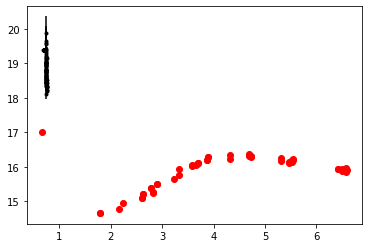

In [67]:
our_path = r"C:\Users\User\OneDrive - mail.tau.ac.il\Desktop\אוניברסיטה\אסטרו נודר\פרויקט קיץ\התחלה של קוד\astro_summer_project\starting with data\excel files\our_data.xlsx"
their_path = r"C:\Users\User\OneDrive - mail.tau.ac.il\Desktop\אוניברסיטה\אסטרו נודר\פרויקט קיץ\התחלה של קוד\astro_summer_project\starting with data\excel files\their_data.xlsx"


our_data = pd.read_excel(our_path, sheet_name='the graph data')

their_data = pd.read_excel(their_path, sheet_name='the graph data')

x_their = their_data.loc[:, 'JD - 2457651.0[day]']
y_their = their_data.loc[:, 'V[mag]']
yerr_their = their_data.loc[:, 'error_V[mag]']

x_our = our_data.loc[:, 'JD - 2457651.0[day]']
y_our = our_data.loc[:, 'V[mag]']
yerr_our = our_data.loc[:, 'error_V[mag]']

plt.errorbar(x_their, y_their, yerr_their, fmt='.k', capsize=0)
plt.errorbar(x_our, y_our, yerr_our, fmt='ro')


time_line = np.linspace(0.6, 7, 100)
n = 3/2
plt.plot(time_line, np.array([get_Mag(n, time) for time in time_line]))


plt.xlabel('JD - 2457651.0[day]')
plt.ylabel('V[mag]')
plt.gca().invert_yaxis()
plt.show()